<a href="https://colab.research.google.com/github/jglombitza/Introspection_tutorial/blob/main/discriminative_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Discriminative localization (CAM)
In this exercise we will create class activation maps (CAMs) for predictions made by a model trained on the MNIST dataset.
 1. Pick out correctly and wrongly classified images classified with a convolutional network.
 2. Create and plot the class activation maps and compare them with the images in order to see which regions lead to the prediction.

In [1]:
from tensorflow import keras
import numpy as np
callbacks = keras.callbacks
layers = keras.layers

print("keras", keras.__version__)

keras 2.8.0


### Load and prepare dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)[...,np.newaxis] / 255.
x_test = x_test.astype(np.float32)[...,np.newaxis] / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### Definition of the model

Define a CNN for discriminative localization. Note that the CNN must use `GlobalAveragePooling2D` after the convolutional part and must not feature more than a single fully-connected layer as output.
Note, you don't have to change the model, just leave it as it is.

In [3]:
model = keras.models.Sequential()
model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                 

### prepare model for training

In [4]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])


In [5]:
results = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=8,
                    verbose=2,
                    validation_split=0.1,
                    )

Epoch 1/8
844/844 - 13s - loss: 1.1588 - accuracy: 0.5934 - val_loss: 0.3358 - val_accuracy: 0.9285 - 13s/epoch - 16ms/step
Epoch 2/8
844/844 - 6s - loss: 0.4323 - accuracy: 0.8668 - val_loss: 0.1824 - val_accuracy: 0.9542 - 6s/epoch - 7ms/step
Epoch 3/8
844/844 - 7s - loss: 0.3067 - accuracy: 0.9083 - val_loss: 0.1480 - val_accuracy: 0.9590 - 7s/epoch - 8ms/step
Epoch 4/8
844/844 - 9s - loss: 0.2503 - accuracy: 0.9262 - val_loss: 0.1054 - val_accuracy: 0.9685 - 9s/epoch - 11ms/step
Epoch 5/8
844/844 - 7s - loss: 0.2197 - accuracy: 0.9337 - val_loss: 0.0882 - val_accuracy: 0.9750 - 7s/epoch - 9ms/step
Epoch 6/8
844/844 - 7s - loss: 0.1953 - accuracy: 0.9413 - val_loss: 0.0915 - val_accuracy: 0.9727 - 7s/epoch - 8ms/step
Epoch 7/8
844/844 - 6s - loss: 0.1844 - accuracy: 0.9447 - val_loss: 0.0834 - val_accuracy: 0.9757 - 6s/epoch - 7ms/step
Epoch 8/8
844/844 - 6s - loss: 0.1695 - accuracy: 0.9485 - val_loss: 0.0762 - val_accuracy: 0.9777 - 6s/epoch - 7ms/step


### Evaluate training

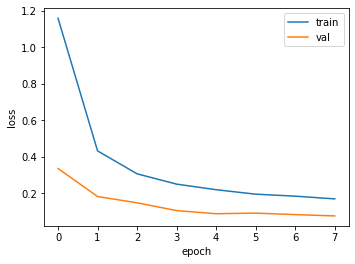

In [6]:
from matplotlib import pyplot as plt
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

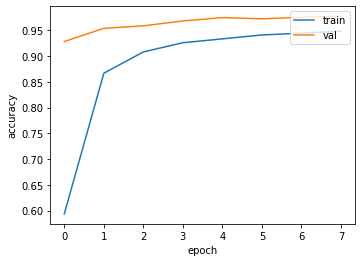

In [7]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

## Create class activation maps

Extract the activations of the last convolutional layer.

In [8]:
conv = model.layers[-4]
conv_func = keras.models.Model(model.inputs, conv.output)
A = conv_func.predict(x_test)
print("Tensorshape of activation tensor", A.shape)

Tensorshape of activation tensor (10000, 14, 14, 32)


In [9]:
W, b = model.layers[-1].get_weights()
print("Tensorshape of weight matrix", W.shape)

Tensorshape of weight matrix (32, 10)




---


**Task:**
Create the class activation maps by omitting the global average pooling operation and applying the weights of the single classification layer to the extracted activations. The operation reads:

$\mathrm{CAM}_{ixyz} = \sum_{ixyz} A_{ixyz} \cdot W_{zc} + b_c$,

where $i$=samples, $x,y$=pixel indices, $z$=feature map, $c$=classes (features of last layer), and $\mathrm{CAM}_{ixyz}$ indicates the tensor of 10 CAMs (one for each class).


Make use of numpy's `np.einsum()`. For example, performing a matrix multiplication $\sum_{j}A_{ij} \cdot B_{jk}$ reads:


 `np.einsum('ij,jk->ik', A, B)`


---



In [ ]:
M = np.einsum()

In [ ]:
y_pred = model.predict(x_test, verbose=1)

y_pred = np.argmax(y_pred, axis=-1).round()
y_true = np.argmax(y_test, axis=-1).round()

### Plot the class activation maps for samples that were correctly and wrongly classifed by the CNN.

In [ ]:
from scipy.special import softmax

def plot_CAM(M, x_test, idx):
    fig = plt.figure(figsize=(15, 6))
    prob = softmax(np.mean(M[idx], axis=(0,1)))

    for i in range(10):
        X = x_test[idx,...].squeeze()  # the image itself
        M1 = M[idx,..., i]  # activation map for digit i
        ax = plt.subplot(2, 5, i+1)

        fig.subplots_adjust(right=0.8, wspace=0.05)
        ax.imshow(X, cmap=plt.cm.gray, extent=(0, 28, 0, 28), alpha=0.75)

        # plot overlay of class activations, perform upsampling by bilinear interpolation
        kwargs = dict(cmap=plt.cm.seismic, extent=(0, 28, 0, 28),
                      interpolation='bilinear', alpha=0.5, vmin=-3*M[idx].std(), vmax=3*M[idx].std())
        img = ax.imshow(M1, **kwargs)
        ax.set_title("CAM for digit %i\n predicted prob: %.3f" % (i, prob[i]))

    cbar = fig.colorbar(img, cax=fig.add_axes([0.99, 0.1, 0.02, 0.8]))
    cbar.set_label('Class activation')
    plt.tight_layout()

### Correctly and wrongly classified samples


---

**Task**:

Find indices where the network performed correct predictions and where the network failed.

---


In [ ]:
idx_correct = 
idx_wrong = 

**Plot correctly classified sample**



In [ ]:
plot_CAM(M, x_test, np.random.choice(idx_correct, 1)[0])

**Plot wrongly classified sample** 

In [ ]:
plot_CAM(M, x_test, np.random.choice(idx_wrong, 1)[0])